# Image Similarity Bandit

In [ ]:
# !pip install -q -U kaggle
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d paramaggarwal/fashion-product-images-dataset

# !unzip /content/fashion-product-images-dataset.zip

# image_path = '/content/fashion-dataset/fashion-dataset/images'

# img_paths = []
# for path in Path(image_path).rglob('*.jpg'):
#     img_paths.append(path)

# styles = pd.read_csv('/content/fashion-dataset/fashion-dataset/styles.csv', error_bad_lines=False)
# styles.head()

# styles_small = styles.sample(1000)

# img_paths_small = [x for x in img_paths if x.stem in styles_small.id.astype('str').tolist()]

# !mkdir -p /content/data/images
# styles_small.to_csv('/content/data/styles.csv', index=False)

# import shutil
# for src_file in img_paths_small:
#     shutil.copy(src_file, '/content/data/images')

# import os
# import zipfile
# def zipdir(path, ziph):
#     # ziph is zipfile handle
#     for root, dirs, files in os.walk(path):
#         for file in files:
#             ziph.write(os.path.join(root, file))
# zipf = zipfile.ZipFile('data.zip', 'w', zipfile.ZIP_DEFLATED)
# zipdir('/content/data', zipf)
# zipf.close()

# !cp data.zip /content/drive/MyDrive/TempData

In [ ]:
# !cp /content/drive/MyDrive/TempData/data.zip /content
# !cp -r /content/drive/MyDrive/TempData/artifacts /content/content/
# !unzip /content/data.zip

In [ ]:
!pip install img2vec_pytorch
!apt install libomp-dev
!pip install --upgrade faiss

In [ ]:
# from pathlib import Path
# from img2vec_pytorch import Img2Vec
# from PIL import Image
# import faiss
# import numpy as np
# import pandas as pd
# import logging
# import pickle
# import os
# import random

In [ ]:
image_path = '/content/content/data/images'
artifact_path = '/content/content/artifacts'

In [ ]:
# img_paths = []
# for path in Path(image_path).rglob('*.jpg'):
#     img_paths.append(path)
# img2vec = Img2Vec(cuda=False)

# def chunks(lst, n):
#     """Yield successive n-sized chunks from lst."""
#     for i in range(0, len(lst), n):
#         yield lst[i:i + n]

# vectors = np.zeros((1,512))
# for paths in chunks(img_paths,50):
#   _x = img2vec.get_vec([Image.open(ipath) for ipath in paths])
#   vectors = np.vstack((vectors,_x))
# vectors.shape

# vectors = vectors[1:,:]
# vectors = vectors.astype(np.float32)

# item_vectors = {ipath.stem:vectors[iindex] for iindex, ipath in enumerate(img_paths)}
# item_paths = {ipath.stem:ipath for ipath in img_paths}
# pickle.dump(item_vectors, open(os.path.join(artifact_path,"item_vectors.p"), "wb"))
# pickle.dump(item_paths, open(os.path.join(artifact_path,"item_paths.p"), "wb"))

# dim = np.array(list(item_vectors.values())).shape[1]
# index = faiss.IndexFlatL2(dim)
# index.add(np.array(list(item_vectors.values())))
# faiss.write_index(index,os.path.join(artifact_path,"vector.index"))

In [ ]:
item_vectors = pickle.load(open(os.path.join(artifact_path,"item_vectors.p"), "rb"))
index = faiss.read_index(os.path.join(artifact_path,"vector.index"))

In [ ]:
def topk_similar(itemid, topk=2):
    _, I = index.search(item_vectors[str(itemid)].reshape(1,-1), topk+1)
    return [list(item_vectors.keys())[i] for i in I.flatten()][1:]

def topk_distance(itemid, topk=2):
    D, I = index.search(item_vectors[str(itemid)].reshape(1,-1), topk+1)
    return {list(item_vectors.keys())[i]:j for (i,j) in zip(I.flatten(),D.flatten())}

def topk_similar2(ivec, topk=5):
    _, I = index.search(ivec.reshape(1,-1), topk)
    return [list(item_vectors.keys())[i] for i in I.flatten()]

In [ ]:
feedbackdf = pd.DataFrame(columns=['imgid','feedback'])

In [ ]:
feedbackdf = feedbackdf.append(pd.Series(('10017','1'), index=['imgid','feedback']),ignore_index=True)
feedbackdf = feedbackdf.append(pd.Series(('10254','1'), index=['imgid','feedback']),ignore_index=True)
feedbackdf

,imgid,feedback
0,10017,1
1,10254,0
2,9685,0
3,30862,0
4,57100,0
5,41777,0
6,30855,0
7,41172,0
8,29154,0
9,34046,0


In [ ]:
epsilon = 0.8
def topk_dice(x):
  if (np.random.random()>epsilon) or (x<20):
    return 20
  else:
    return 5

In [ ]:
def recommend():
  _x = feedbackdf[feedbackdf.feedback=='1']
  impressions = feedbackdf.imgid.unique()
  likedlist = _x.imgid.unique()
  _x = [item_vectors[x] for x in likedlist]
  _x = np.array(_x)
  weights=np.arange(_x.shape[0])+1
  _x = np.average(_x, axis=0, weights=weights)
  _x = _x.astype(np.float32)
  topk = topk_dice(len(impressions))
  print(topk)
  _x = topk_similar2(_x,topk)
  _x = [x for x in _x if x not in impressions]
  _x = random.choice(_x)
  _y = '{}/{}.jpg'.format(image_path, _x)
  _y = Image.open(_y)
  return _x, _y

20


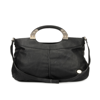

In [ ]:
_x,_y = recommend()
_y.resize((100,100))

In [ ]:
from google.colab import widgets
import ipywidgets
from IPython.display import display, clear_output

pd.set_option("max_colwidth", None)

output = ipywidgets.widgets.Output()
fbs = w.ToggleButtons(options=["Like", "Don't Like"])

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    clear_output()
    _x,_y = recommend()
    global feedbackdf
    global fbs
    _z = '1' if fbs=='Like' else '0'
    feedbackdf = feedbackdf.append(pd.Series((_x,_z), index=['imgid','feedback']),ignore_index=True)
    display(_y.resize((300,300)))
  
button = ipywidgets.widgets.Button(description='Recommend next')
button.on_click(on_button_clicked)

In [ ]:
display(button)
display(output)
display(fbs)